In [1]:
import os
import h5py
import numpy as np
import torch
from tensorflow.keras import models, layers, preprocessing, datasets
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, ToTensor, EnsureChannelFirst
from sklearn.model_selection import train_test_split
import cv2
from torch.optim import Adam
import torch

In [2]:
def imageGenerator():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    output_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                image = np.array(f['cjdata/image']).T
                label = int(np.array(f['cjdata/label'])[0,0])
    
            image = image.astype(np.float64)
            im_norm = 255*(image-image.min())/(image.max()-image.min())
            im_uint8 = im_norm.astype(np.uint8)

            file_name_base = os.path.splitext(file_name)[0]
            output_file_path = os.path.join(output_folder,file_name_base + '.jpg')
    
            im_pil = Image.fromarray(im_uint8)
            im_pil = im_pil.resize(img_size)
            datas.append((np.array(im_pil,dtype=np.float32),label))
            
            im_pil.save(output_file_path)
    #return datas

In [3]:
#imageGeneratior()

In [4]:
def imageProcesser():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                label = int(np.array(f['cjdata/label'])[0,0])-1
                image = np.array(f['cjdata/image']).T
                tumor_border = np.array(f['cjdata/tumorBorder'])
                tumor_mask = np.array(f['cjdata/tumorMask']).T
                
            eps = 1e-8
            
            image = image.astype(np.float64)
            image = 255*(image-image.min())/(image.max()-image.min() + eps)
            image = cv2.resize(image,img_size)
            image_norm = image.astype(np.float32)/255.0
            image = np.expand_dims(image_norm,axis=0)

            tumor_mask = tumor_mask.astype(np.float64)
            tumorMask = 255*(tumor_mask-tumor_mask.min())/(tumor_mask.max()-tumor_mask.min() + eps)
            tumorMask = cv2.resize(tumorMask,img_size)
            tumor_mask_norm = tumorMask.astype(np.float32)/255.0
            mask = np.expand_dims(tumor_mask_norm,axis=0)

            
            datas.append((image,mask))
    return datas

In [5]:
datas = imageProcesser()
X = datas[0]
y = datas[1]

In [7]:
#https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

In [8]:
train_size = int(0.8*len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = torch.utils.data.random_split(datas,[train_size,val_size])

train = DataLoader(train_datas,batch_size=8,shuffle=True)
val = DataLoader(val_datas,batch_size=8,shuffle=True)

In [9]:
model = UNet(
    spatial_dims=2,
    in_channels=1,       
    out_channels=1,      
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to("cpu")

In [10]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
loss_function = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(35):
    model.train()
    epoch_loss = 0
    for i, (images, masks) in enumerate(train):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train)}")

Epoch 1, Loss: 0.9439009635766865
Epoch 2, Loss: 0.9338682235646325
Epoch 3, Loss: 0.929985972685612
Epoch 4, Loss: 0.9265964122470893
Epoch 5, Loss: 0.9226462318765224
Epoch 6, Loss: 0.9191765750269937
Epoch 7, Loss: 0.9150226310332358
Epoch 8, Loss: 0.9100603304002495
Epoch 9, Loss: 0.9047582205809677
Epoch 10, Loss: 0.8982692428831168
Epoch 11, Loss: 0.8902435357096917
Epoch 12, Loss: 0.8809805228966455
Epoch 13, Loss: 0.8704373287067351
Epoch 14, Loss: 0.8594792803646298
Epoch 15, Loss: 0.8468948373577105
Epoch 16, Loss: 0.8344751514906992
Epoch 17, Loss: 0.823887353999607
Epoch 18, Loss: 0.8102170159063432
Epoch 19, Loss: 0.7949415280298612
Epoch 20, Loss: 0.77958830948373
Epoch 21, Loss: 0.7629262556470566
Epoch 22, Loss: 0.747806482866455
Epoch 23, Loss: 0.7316355101448705
Epoch 24, Loss: 0.7172859185875822
Epoch 25, Loss: 0.7016925409873068
Epoch 26, Loss: 0.6811841298198079
Epoch 27, Loss: 0.6621437607642494
Epoch 28, Loss: 0.6429693459105414
Epoch 29, Loss: 0.6249371050623418

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = X[0].astype(np.float64)
#image = 255*(image-image.min())/(image.max()-image.min() + (1e-8))
#image = cv2.resize(image,(256,256))
#image_norm = image.astype(np.float32)/255.0
#image = np.expand_dims(image_norm,axis=0)

image = torch.tensor(image,dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    preds = torch.sigmoid(output)
    binary_preds = (preds>0.3).float()
   

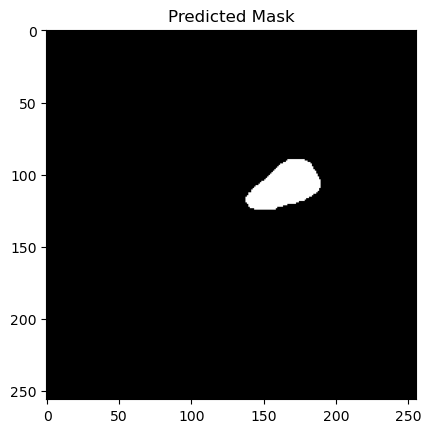

In [14]:
import matplotlib.pyplot as plt

plt.imshow(binary_preds[0][0].cpu(), cmap='gray')   # első batch első kép
plt.title("Predicted Mask")
plt.show()

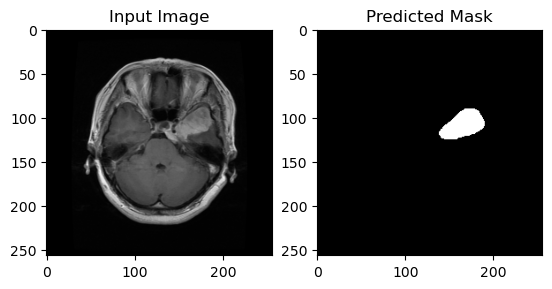

In [15]:
plt.subplot(1,2,1)
plt.imshow(image[0][0].cpu(), cmap='gray')
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(binary_preds[0][0].cpu(), cmap='gray')
plt.title('Predicted Mask')
plt.show()

In [16]:
#torch.save(model.state_dict(),"C:/Users/marto/Desktop/Thesis/backend/models/unet_weights.pth")